In [70]:
import os
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import mplhep

plt.style.use(mplhep.style.CMS)

# ============================
# 1. NanoAOD Processing
# ============================
def process_nanogen_files(file_paths, label="NanoAod_SM"):
    combined_data = {}

    # Load data
    for file_path in file_paths:
        with uproot.open(file_path) as f:
            for tree_name in f.keys():
                clean_key = tree_name.split(";")[0]
                tree = f[tree_name]
                arr = tree.arrays()
                flat_array = arr[""]
                if clean_key not in combined_data:
                    combined_data[clean_key] = [flat_array]
                else:
                    combined_data[clean_key].append(flat_array)

    # Combine arrays across files
    combined_data = {k: ak.concatenate(v) for k, v in combined_data.items()}

    # Apply lepton pt > 0 mask only for ReweightedSM
    if label == "NanoAod_smeft@ReweightedSM":
        gen_l_pt = ak.flatten(combined_data["gen_l_pt"], axis=None)
        gen_lbar_pt = ak.flatten(combined_data["gen_lbar_pt"], axis=None)
        mask_file = (gen_l_pt > 0) & (gen_lbar_pt > 0)
    
        # Apply the mask only to relevant observables
        file_data = {k: v[mask_file] for k, v in combined_data.items()}
    else:
        # For other labels, use the unmasked flattened data
        file_data = {k: v for k, v in combined_data.items()}


    # Extract observables
    B1 = ak.to_numpy(ak.flatten(file_data["gen_hel_B1"], axis=-1))
    B2 = ak.to_numpy(ak.flatten(file_data["gen_hel_B2"], axis=-1))
    C = ak.to_numpy(ak.flatten(file_data["gen_hel_C"], axis=-1))
    ll_cHel = ak.to_numpy(file_data["gen_ll_cHel"])

    # Handle weights
    if label == "NanoAod_smeft@ReweightedSM":
        event_weight = ak.to_numpy(file_data["event_weight"][:, 200])
    else:
        event_weight = np.ones(len(file_data["gen_ll_cHel"]))

    # Build observable map
    observable_map = {
        "gen_b1k": B1[:, 0], "gen_b2k": B2[:, 0],
        "gen_b1r": B1[:, 1], "gen_b2r": B2[:, 1],
        "gen_b1n": B1[:, 2], "gen_b2n": B2[:, 2],
        "gen_c_kk": C[:, 0, 0], "gen_c_kr": C[:, 0, 1], "gen_c_kn": C[:, 0, 2],
        "gen_c_rk": C[:, 1, 0], "gen_c_rr": C[:, 1, 1], "gen_c_rn": C[:, 1, 2],
        "gen_c_nk": C[:, 2, 0], "gen_c_nr": C[:, 2, 1], "gen_c_nn": C[:, 2, 2],
        "gen_ll_cHel": ll_cHel
    }

    return observable_map, event_weight
# ============================
# 2. MiniAOD Processing
# ============================
def process_miniaod_files(directory_path, flavors, n_files):
    desired_files = [
        f"2016preVFP/spinCorrInput_2016preVFP_January2023/Nominal/{flavor}/{flavor}_ttbarsignalplustau_fromDilepton_2016ULpreVFP_{i}.root"
        for flavor in flavors for i in range(n_files)
    ]
    file_paths = [os.path.join(directory_path, f) for f in desired_files]
    trees = [uproot.open(fp)['ttBar_treeVariables_step0'] for fp in file_paths]
    file_data = uproot.concatenate(trees)

    observable_keys = [
        'gen_b1k', 'gen_b2k', 'gen_b1r', 'gen_b2r', 'gen_b1n', 'gen_b2n',
        'gen_c_kk', 'gen_c_kr', 'gen_c_kn', 'gen_c_rk', 'gen_c_rr', 'gen_c_rn',
        'gen_c_nk', 'gen_c_nr', 'gen_c_nn', 'gen_ll_cHel'
    ]

    observable_powheg = {k: ak.to_numpy(file_data[k]) for k in observable_keys if k in file_data.fields}
    return observable_powheg, np.ones(len(next(iter(observable_powheg.values()))))

# ============================
# 2b. MiniAOD EFT Processing with Mask
# ============================
def process_miniaod_eft_files(directory_path, flavors):
    desired_files = [
        f"{flavor}/{flavor}_ttto2l2nu_jet_smeft_mtt_0to700_2016preVFP.root"
        for flavor in flavors
    ] + [
        f"{flavor}/{flavor}_ttto2l2nu_jet_smeft_mtt_700to900_2016preVFP.root"
        for flavor in flavors
    ] + [
        f"{flavor}/{flavor}_ttto2l2nu_jet_smeft_mtt_900toInf_2016preVFP.root"
        for flavor in flavors
    ]

    file_paths = [os.path.join(directory_path, f) for f in desired_files]
    trees = [uproot.open(fp)['ttBar_treeVariables_step0'] for fp in file_paths]
    file_data = uproot.concatenate(trees)

    # Apply the lepton pt mask
    gen_l_pt = file_data["gen_l_pt"]
    gen_lbar_pt = file_data["gen_lbar_pt"]
    mask_file = (gen_l_pt > 0) & (gen_lbar_pt > 0)
    masked_data = file_data[mask_file]

    observable_keys = [
        'gen_b1k', 'gen_b2k', 'gen_b1r', 'gen_b2r', 'gen_b1n', 'gen_b2n',
        'gen_c_kk', 'gen_c_kr', 'gen_c_kn', 'gen_c_rk', 'gen_c_rr', 'gen_c_rn',
        'gen_c_nk', 'gen_c_nr', 'gen_c_nn', 'gen_ll_cHel'
    ]

    observable_eft = {
        k: ak.to_numpy(masked_data[k])
        for k in observable_keys if k in masked_data.fields
    }

    weights_eft = ak.to_numpy(masked_data["mgWeights"][:, 200])  # EFT reweighted SM

    return observable_eft, weights_eft

# ============================
# 3. Plotting Function
# ============================
def plot_observables(obs_dict, weights, xlabel, save_name, plot_dir, save):
    fig, (ax, ax_ratio) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True, figsize=(10, 8))
    colors = ['black', 'red', 'blue', 'green']

    reference_label = list(obs_dict.keys())[0]
    reference_counts = None
    reference_errors = None
    bin_edges = None
    global_max = 0

    for i, label in enumerate(obs_dict):
        obs = obs_dict[label]
        weight = weights[label]

        bins = np.histogram_bin_edges(obs, bins=6)
        counts, _ = np.histogram(obs, bins=bins, weights=weight, density=True)
        sumw, _ = np.histogram(obs, bins=bins, weights=weight)
        sumw2, _ = np.histogram(obs, bins=bins, weights=np.square(weight))

        bin_widths = np.diff(bins)
        errors = np.sqrt(sumw2) / (sumw * bin_widths)
        errors = np.nan_to_num(errors, nan=0.0, posinf=0.0, neginf=0.0)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        global_max = max(global_max, np.max(counts + errors))

        ax.step(bins, np.append(counts, counts[-1]), where='post', color=colors[i % len(colors)], linewidth=2, label=label)
        ax.vlines([bins[0], bins[-1]], 0, [counts[0], counts[-1]], color=colors[i % len(colors)], linewidth=2)
        ax.errorbar(bin_centers, counts, yerr=errors, fmt='o', color=colors[i % len(colors)], markersize=4, capsize=2)

        if i == 0:
            reference_counts = counts
            reference_errors = errors
            bin_edges = bins
        else:
            ratio = np.divide(counts, reference_counts, out=np.zeros_like(counts), where=reference_counts != 0)
            rel_err_ref = np.divide(reference_errors, reference_counts, out=np.zeros_like(reference_errors), where=reference_counts != 0)
            rel_err = np.divide(errors, counts, out=np.zeros_like(errors), where=counts != 0)
            ratio_err = ratio * np.sqrt(rel_err**2 + rel_err_ref**2)
            ax_ratio.step(bins, np.append(ratio, ratio[-1]), where='post', color=colors[i % len(colors)])
            ax_ratio.errorbar(bin_centers, ratio, yerr=ratio_err, fmt='o', color=colors[i % len(colors)], markersize=4, capsize=2)

    for edge in [bin_edges[0], bin_edges[-1]]:
        ax.axvline(edge, color='gray', linestyle=':', linewidth=1)
        ax_ratio.axvline(edge, color='gray', linestyle=':', linewidth=1)

    ax.set_ylabel("Normalized Events")
    ax.set_ylim(0, 1.1 * global_max)
    ax.legend(loc='best')
    mplhep.cms.label("Work in progress", data=True, ax=ax, loc=0)

    ax_ratio.set_xlabel(xlabel)
    ax_ratio.set_ylabel("Ratio")
    ax_ratio.axhline(1, color='gray', linestyle='--')
    ax_ratio.set_ylim(0.5, 1.5)
    ax_ratio.legend().remove()

    plt.tight_layout()
    if save:
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(f"{plot_dir}/{save_name}.png")
    plt.show()

# ============================
# 4. Comparison Wrapper
# ============================
def compare_and_plot_observables(obs_map_1, label_1, weights_1,
                                 obs_map_2, label_2, weights_2,
                                 plot_function=plot_observables,
                                 output_dir=None,
                                 save=False):
    plot_dir = output_dir if output_dir else f"plots/{label_1}_vs_{label_2}"
    
    if save:
        os.makedirs(plot_dir, exist_ok=True)

    common_keys = set(obs_map_1.keys()) & set(obs_map_2.keys())
    missing_keys = set(obs_map_1.keys()) ^ set(obs_map_2.keys())
    if missing_keys:
        print(" Missing observables:")
        for key in sorted(missing_keys):
            print(f"  - {key}")

    observable_labels = {
        "gen_b1k": r"$\cos\theta_1^k$", "gen_b2k": r"$\cos\theta_2^k$",
        "gen_b1r": r"$\cos\theta_1^r$", "gen_b2r": r"$\cos\theta_2^r$",
        "gen_b1n": r"$\cos\theta_1^n$", "gen_b2n": r"$\cos\theta_2^n$",
        "gen_c_kk": r"$\cos\theta_1^k \cos\theta_2^k$", "gen_c_kr": r"$\cos\theta_1^k \cos\theta_2^r$", "gen_c_kn": r"$\cos\theta_1^k \cos\theta_2^n$",
        "gen_c_rk": r"$\cos\theta_1^r \cos\theta_2^k$", "gen_c_rr": r"$\cos\theta_1^r \cos\theta_2^r$", "gen_c_rn": r"$\cos\theta_1^r \cos\theta_2^n$",
        "gen_c_nk": r"$\cos\theta_1^n \cos\theta_2^k$", "gen_c_nr": r"$\cos\theta_1^n \cos\theta_2^r$", "gen_c_nn": r"$\cos\theta_1^n \cos\theta_2^n$",
        "gen_ll_cHel": r"$\cos\phi$"
    }

    for obs_name in sorted(common_keys):
        obs1 = obs_map_1[obs_name]
        obs2 = obs_map_2[obs_name]

        w1 = weights_1 if len(weights_1) == len(obs1) else np.ones_like(obs1)
        w2 = weights_2 if len(weights_2) == len(obs2) else np.ones_like(obs2)

        plot_function(
            plot_dir=plot_dir,
            obs_dict={label_1: obs1, label_2: obs2},
            weights={label_1: w1, label_2: w2},
            xlabel=observable_labels.get(obs_name, obs_name),
            save_name=obs_name,
            save=save
        )


In [71]:
# Example use case: compare NanoAOD SM and NanoAOD reweighted to SM
nanogen_ttbar=[
        "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/ee_nanogen_powheg_ttbar_dileptonic.root",
        "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/emu_nanogen_powheg_ttbar_dileptonic.root",
        "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/mumu_nanogen_powheg_ttbar_dileptonic.root"
    ]
nanogen_ttbar1=[
        "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_ttbar_root_files/ee_nanogen_powheg_ttbar_dileptonic.root",
        "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_ttbar_root_files/emu_nanogen_powheg_ttbar_dileptonic.root",
        "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_ttbar_root_files/mumu_nanogen_powheg_ttbar_dileptonic.root"
    ]
nanogen_eft_central=[
        "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/ee_nanogen_central_sample_dileptonic.root",
        "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/emu_nanogen_central_sample_dileptonic.root",
        "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/mumu_nanogen_central_sample_dileptonic.root"
    ]
nanogen_eft_central1=[
        "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_central_root_files/ee_nanogen_powheg_ttbar_dileptonic.root",
        "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_central_root_files/emu_nanogen_powheg_ttbar_dileptonic.root",
        "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_central_root_files/mumu_nanogen_powheg_ttbar_dileptonic.root"
    ]
nanogen_noeft=[
    "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/ee_nanogen_noEFT_dileptonic.root",
    "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/emu_nanogen_noEFT_dileptonic.root",
    "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/mumu_nanogen_noEFT_dileptonic.root"
]

obs_nanogen_SM, w_nanogen_SM = process_nanogen_files(nanogen_ttbar, label="NanoAod_powhegv2@ttbar")
obs_nanogen_SM1, w_nanogen_SM1 = process_nanogen_files(nanogen_ttbar1, label="NanoAod_powhegv2@ttbar1")
obs_nanogen_RW, w_nanogen_RW = process_nanogen_files(nanogen_eft_central, label="NanoAod_smeft@ReweightedSM")
#obs_nanogen_RW1, w_nanogen_RW1 = process_nanogen_files(nanogen_eft_central1, label="NanoAod_smeft@ReweightedSM1")
obs_nanogen_noEFT, w_nanogen_noEFT = process_nanogen_files(nanogen_noeft, label="Nanogen_smeft@sm")





In [72]:
obs_miniaod_SM, w_miniaod_SM = process_miniaod_files('/eos/purdue/store/user/jthieman/', ['ee', 'emu', 'mumu'], 11)

In [73]:
obs_miniaod_RW, w_miniaod_RW = process_miniaod_eft_files(directory_path="/eos/purdue/store/user/lingqian/fullrun2_eft_minitrees/spinCorrInput_2016preVFP/Nominal",
                                                           flavors=["ee", "emu", "mumu"])


KeyboardInterrupt: 

In [68]:
nanogen_cmseft=[
    "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/ee_nanogen_cmseft_dileptonic.root",
    "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/emu_nanogen_cmseft_dileptonic.root",
    "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/mumu_nanogen_cmseft_dileptonic.root"
]
obs_nanoaod_cmseft,w_nanoaod_cmseft=process_nanogen_files(nanogen_cmseft, label="NanoAod_cmseft@ReweightedSM")

/tmp/ipykernel_2252/2719531167.py:187: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_ratio.legend().remove()


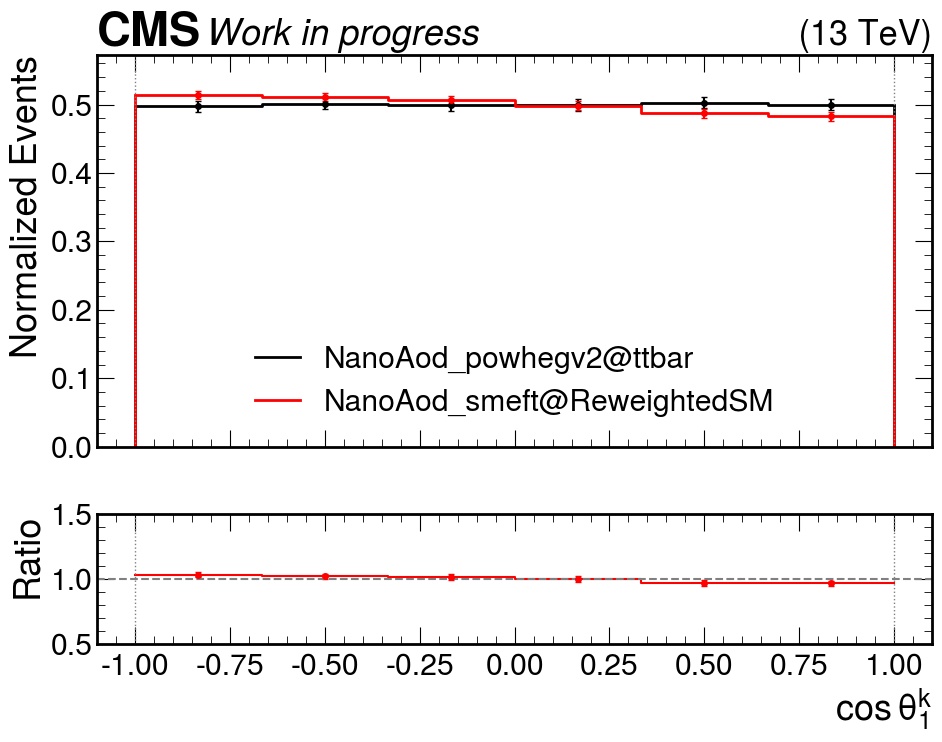

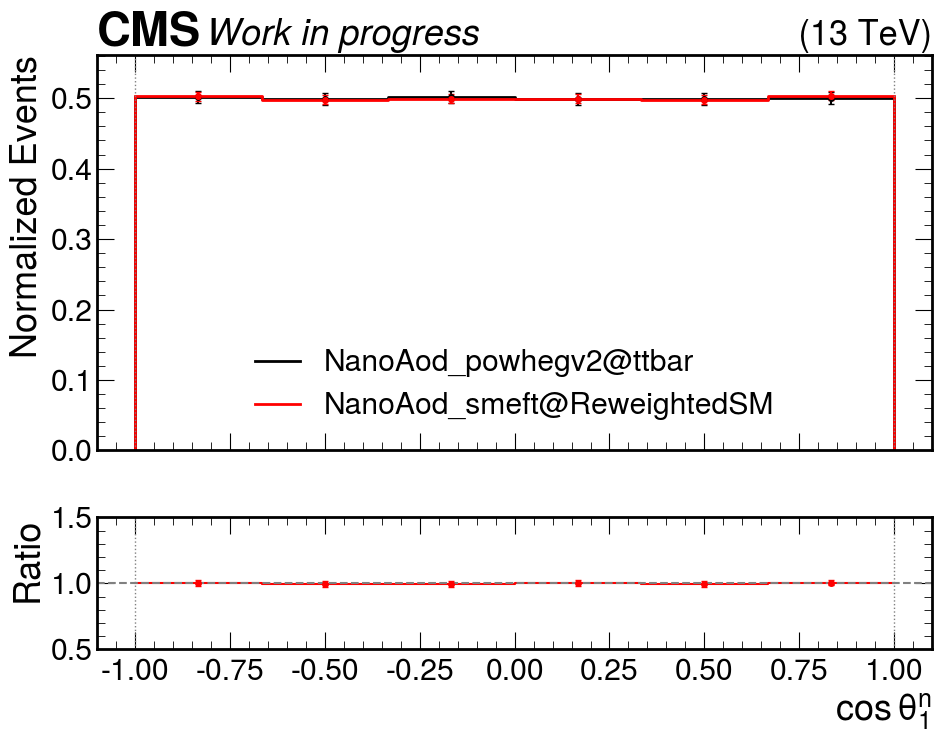

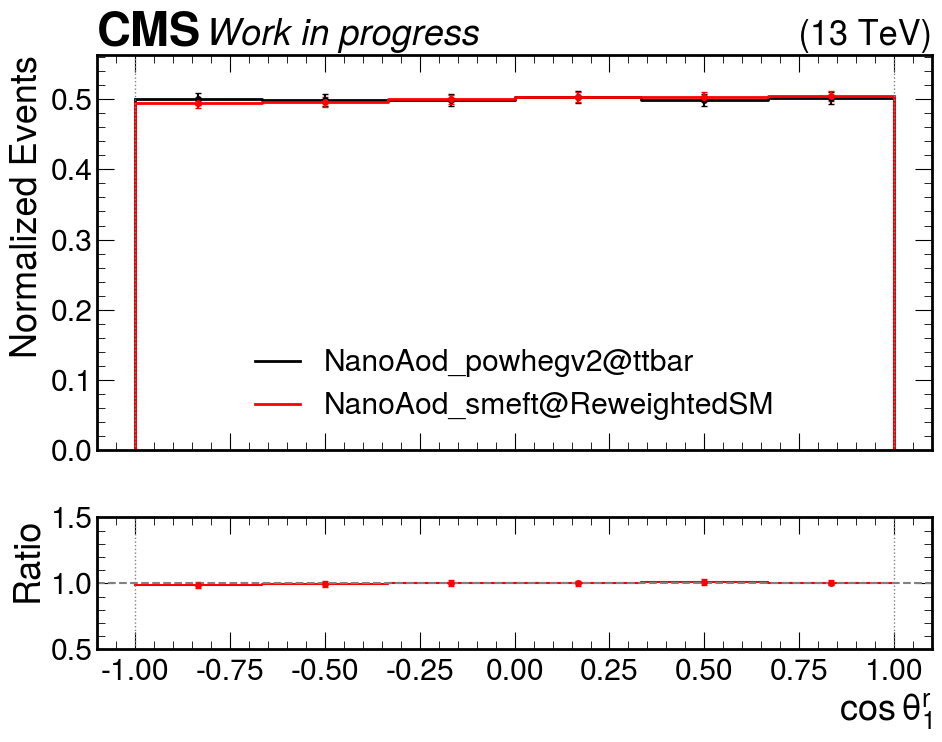

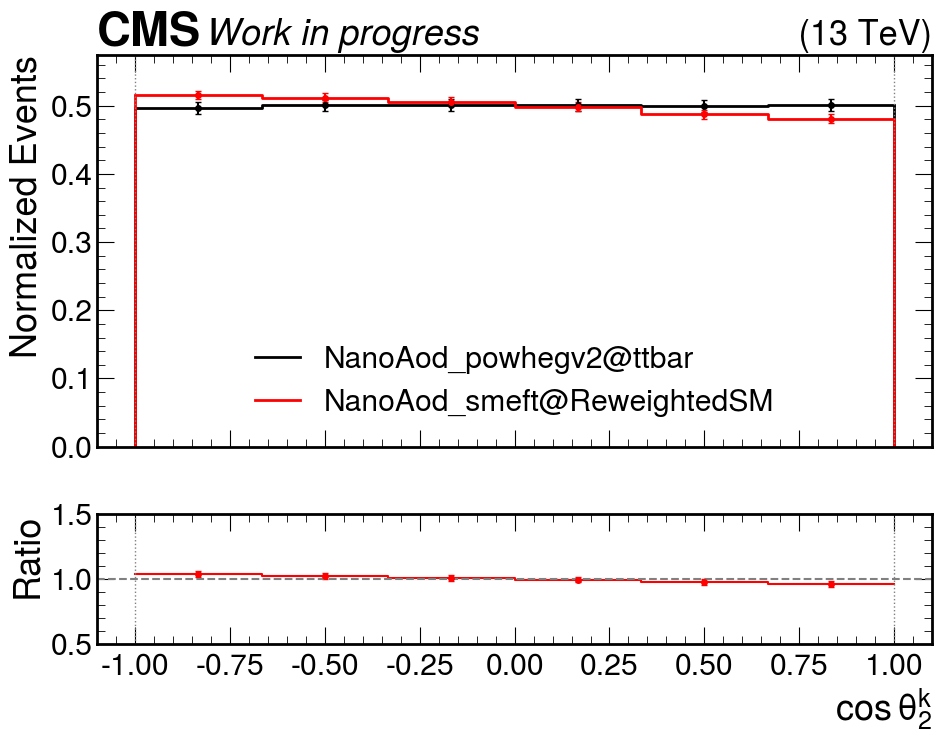

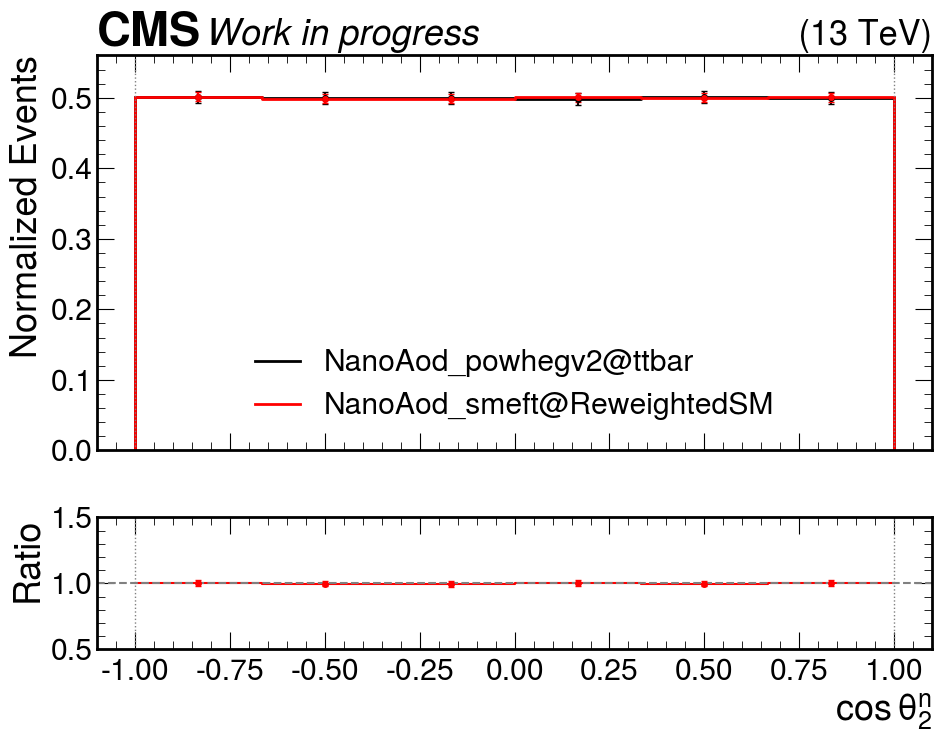

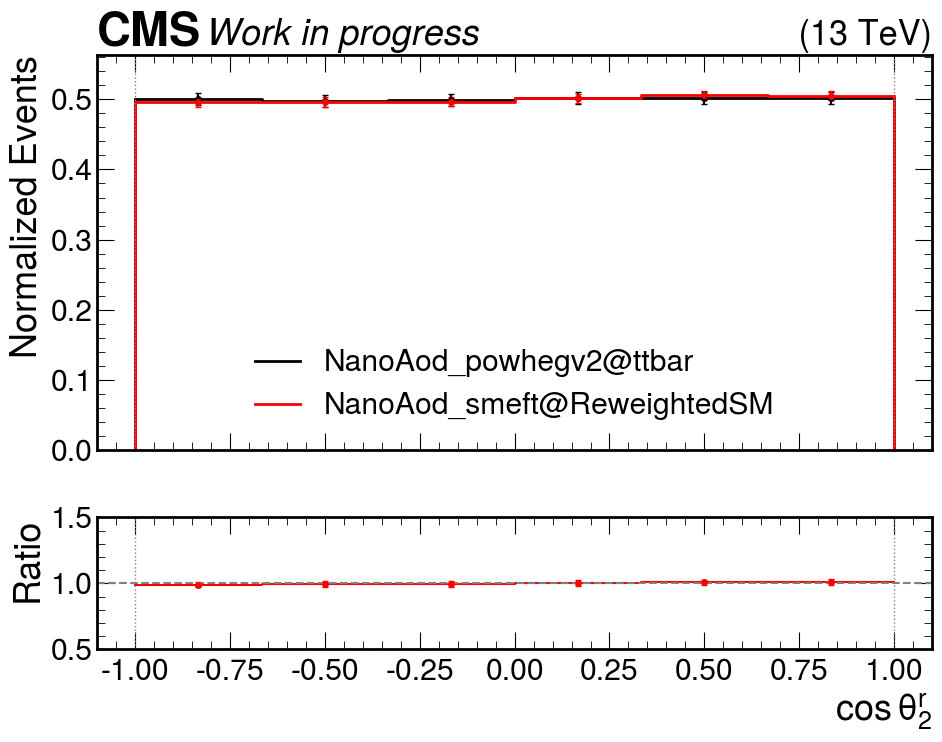

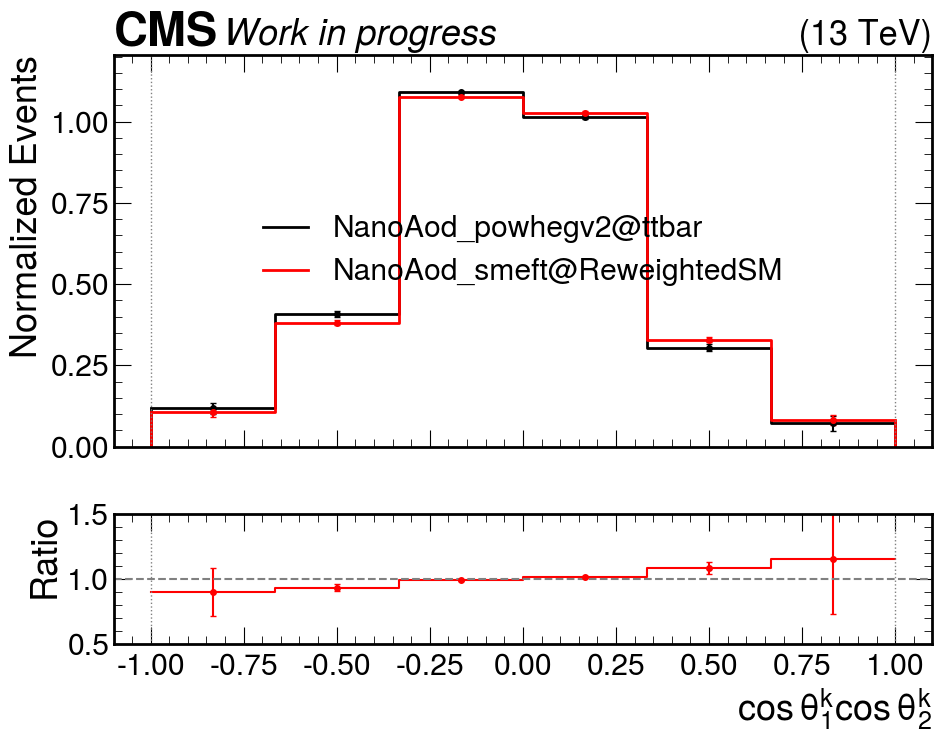

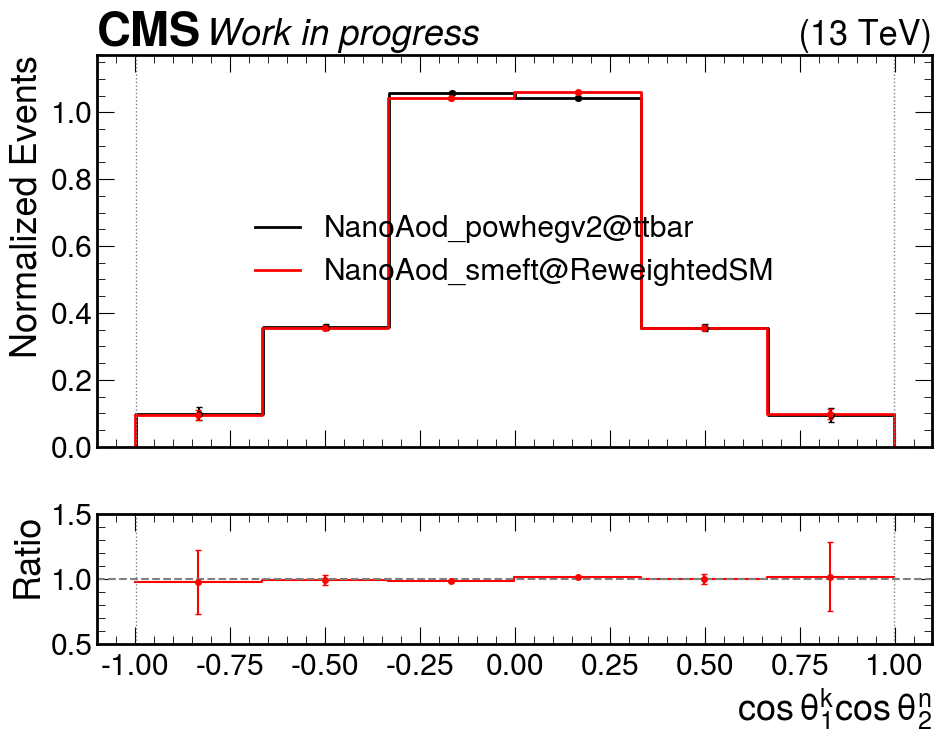

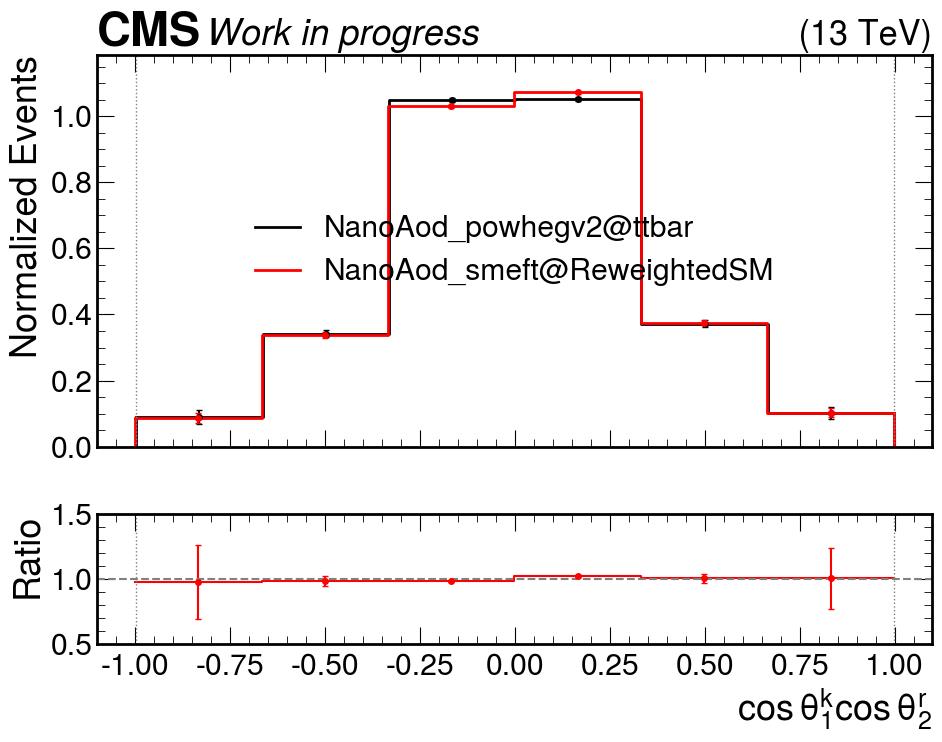

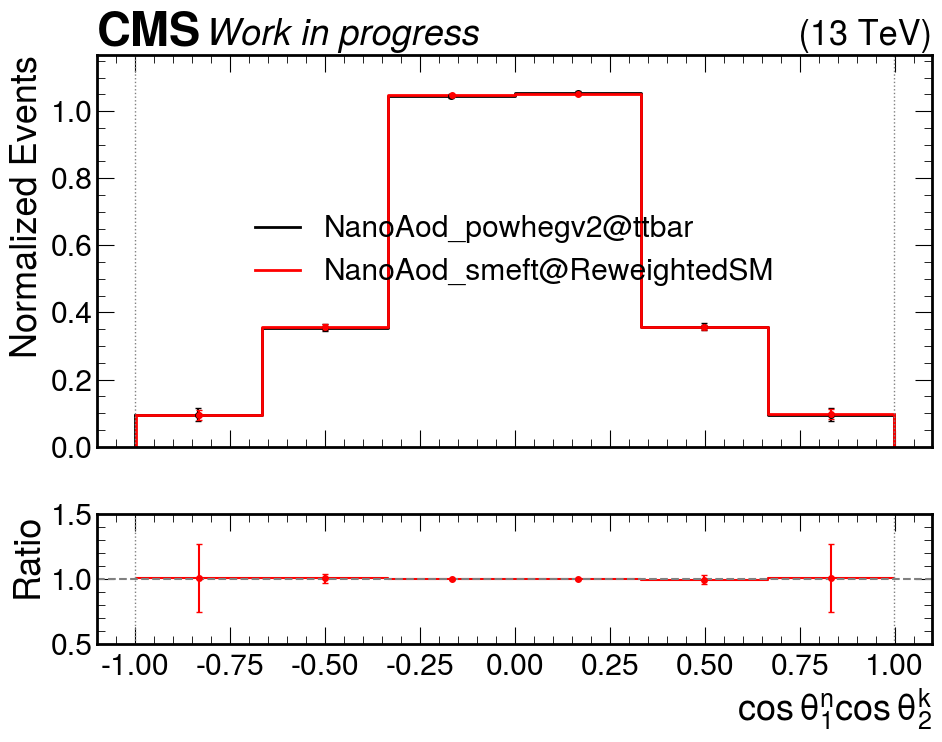

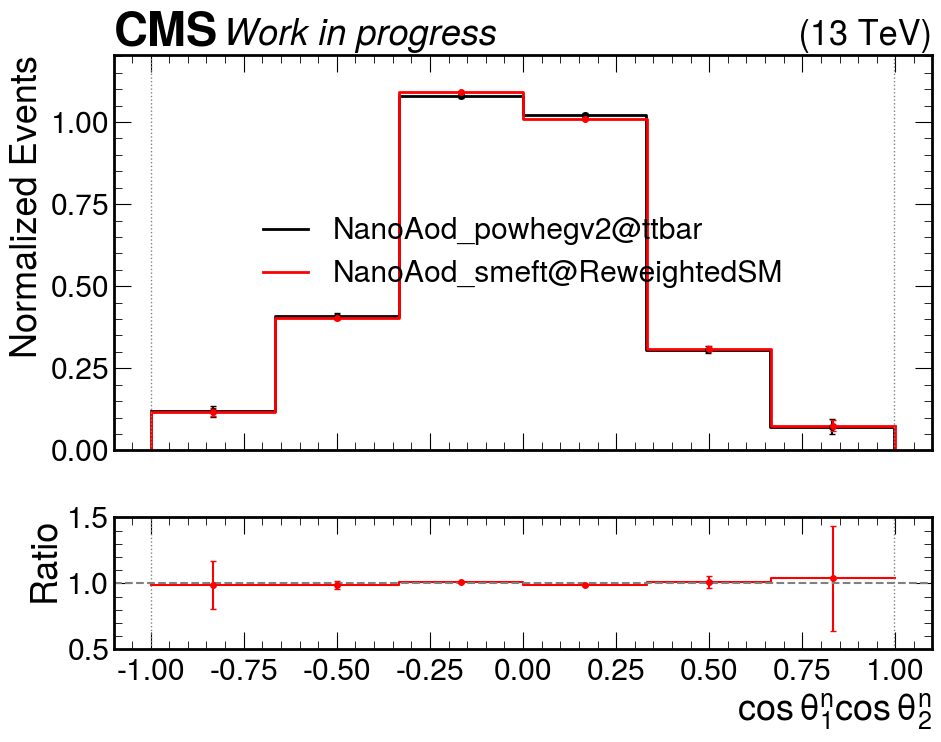

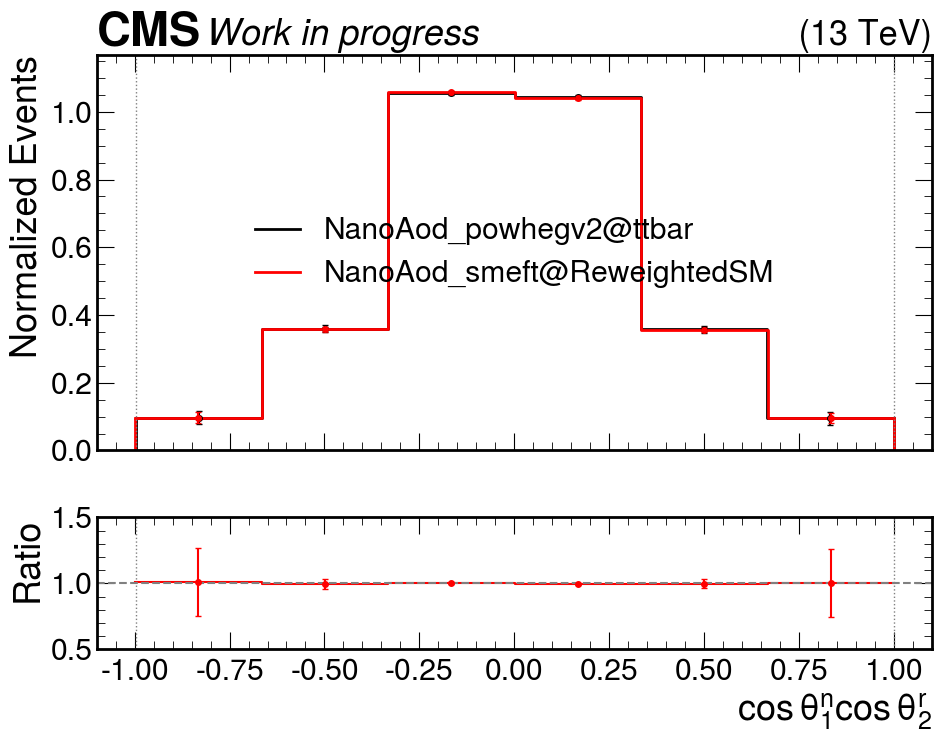

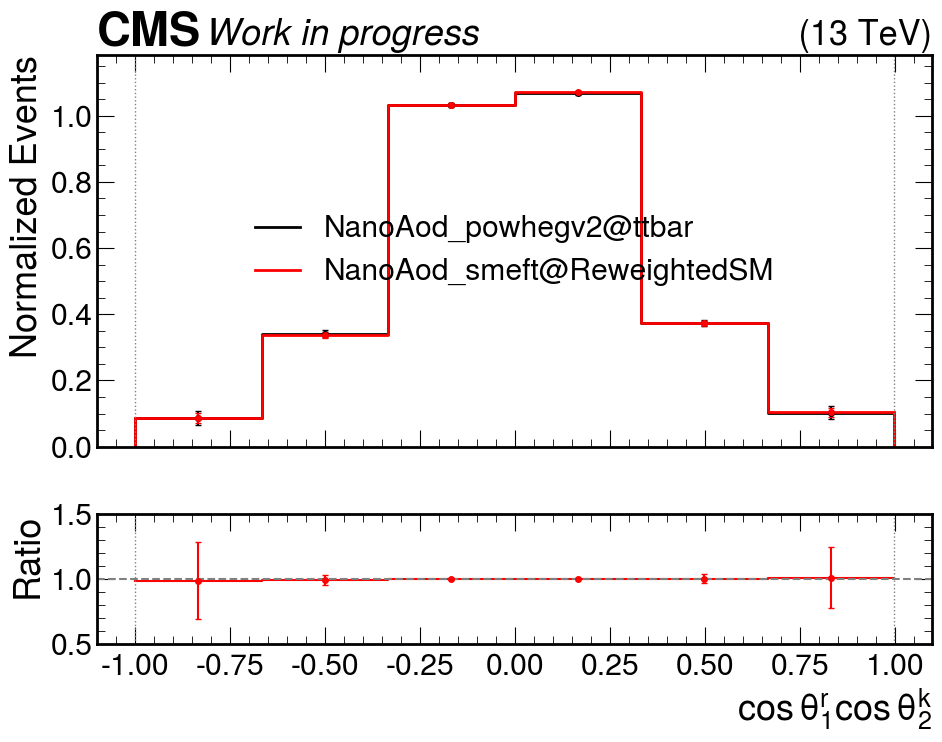

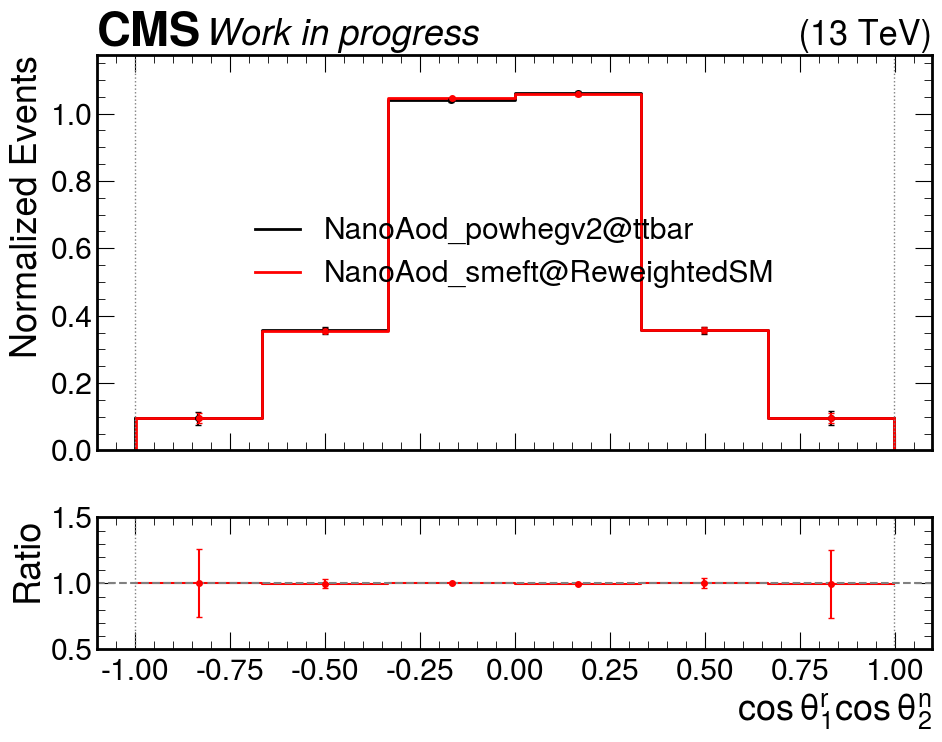

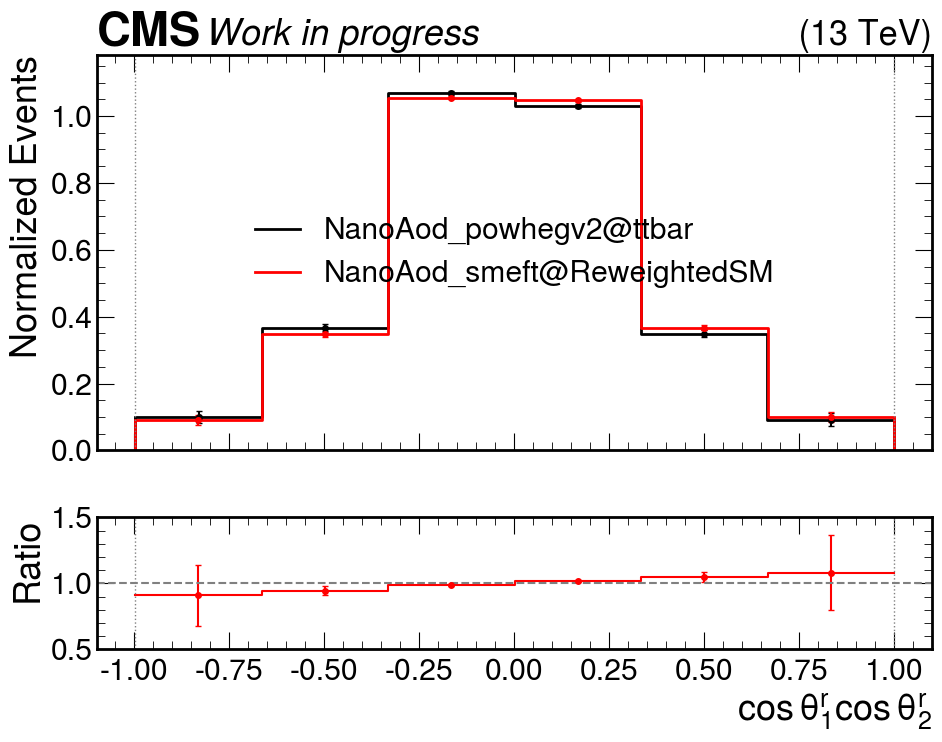

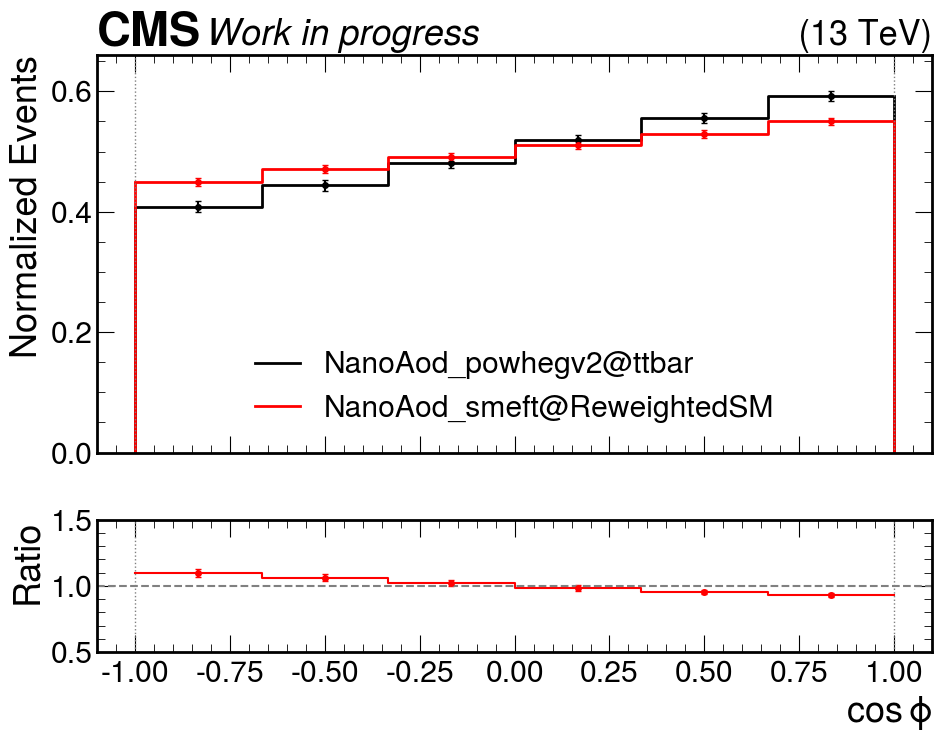

In [74]:
#compare_and_plot_observables(obs_map_1=obs_nanogen_SM, label_1="NanoAod_powhegv2@ttbar", weights_1=w_nanogen_SM,obs_map_2=obs_miniaod_SM, label_2="MiniAod_powhegv2@ttbar", weights_2=w_miniaod_SM, save=False)
#compare_and_plot_observables(obs_map_1=obs_nanogen_SM, label_1="NanoAod_powhegv2@ttbar", weights_1=w_nanogen_SM,obs_map_2=obs_nanogen_RW, label_2="NanoAod_smeft@ReweightedSM", weights_2=w_nanogen_RW, save=False)
#compare_and_plot_observables(obs_map_1=obs_nanogen_SM, label_1="NanoAod_powhegv2@ttbar", weights_1=w_nanogen_SM,obs_map_2=obs_nanogen_noEFT, label_2="Nanogen_smeft@sm", weights_2=w_nanogen_noEFT)
#compare_and_plot_observables(obs_map_1=obs_nanogen_RW, label_1="NanoAod_smeft@ReweightedSM", weights_1=w_nanogen_RW,obs_map_2=obs_nanogen_noEFT, label_2="Nanogen_smeft@sm", weights_2=w_nanogen_noEFT)
#compare_and_plot_observables(obs_map_1=obs_miniaod_SM, label_1="MiniAod_powhegv2@ttbar", weights_1=w_miniaod_SM,obs_map_2=obs_nanogen_RW, label_2="NanoAod_smeft@ReweightedSM", weights_2=w_nanogen_RW)
#compare_and_plot_observables(obs_map_1=obs_nanogen_RW, label_1="NanoAod_smeft@ReweightedSM", weights_1=w_nanogen_RW,obs_map_2=obs_nanogen_RW1, label_2="NanoAod_smeft@ReweightedSM1", weights_2=w_nanogen_RW1)
#compare_and_plot_observables(obs_map_1=obs_nanogen_RW, label_1="NanoAod_smeft@ReweightedSM", weights_1=w_nanogen_RW,obs_map_2=obs_miniaod_RW, label_2="MiniAod_smeft@ReweightedSM", weights_2=w_miniaod_RW, save=True)
#compare_and_plot_observables(obs_map_1=obs_miniaod_SM, label_1="MiniAod_powhegv2@ttbar", weights_1=w_miniaod_SM,obs_map_2=obs_miniaod_RW, label_2="MiniAod_smeft@ReweightedSM", weights_2=w_miniaod_RW, save=True)
#compare_and_plot_observables(obs_map_1=obs_nanogen_SM, label_1="NanoAod_powhegv2@ttbar", weights_1=w_nanogen_SM,obs_map_2=obs_nanoaod_cmseft, label_2="NanoAod_cmseft@ReweightedSM", weights_2=w_nanoaod_cmseft, save=True)



In [55]:
import numpy as np
from uncertainties import ufloat

def compute_spin_corr_coefficients(observables_dict, weights_array, bins=20, range_=(-1, 1)):
    """
    Compute spin correlation coefficients from observables and weights.

    Parameters:
    - observables_dict (dict): Dictionary with keys as observable names and values as arrays
    - weights_array (np.ndarray): 1D array of weights (same length as each observable array)
    - bins (int): Number of bins for asymmetry computation
    - range_ (tuple): Range for histogram binning

    Returns:
    - results_dict (dict): { observable_name : (value, uncertainty) }
    """

    # Constants
    constant_factor_Cij = -4.0  
    constant_factor_CijCji = -16 / np.pi  
    constant_factor_D = -2
    constant_factor_b = 2

    def binned_assy(obs, weights):
        bin_edges = np.linspace(*range_, bins + 1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        hist, _ = np.histogram(obs, bins=bin_edges, weights=weights)
        hist_err = np.sqrt(np.histogram(obs, bins=bin_edges, weights=weights**2)[0])

        pos = bin_centers > 0
        neg = bin_centers < 0

        N1 = ufloat(np.sum(hist[pos]), np.sqrt(np.sum(hist_err[pos]**2)))
        N2 = ufloat(np.sum(hist[neg]), np.sqrt(np.sum(hist_err[neg]**2)))
        A = (N1 - N2) / (N1 + N2)
        return A

    # Precompute compound observables
    obs = observables_dict
    combined_observables = {
        r'$C_{rk}+C_{kr}$': obs['gen_c_rk'] + obs['gen_c_kr'],
        r'$C_{nk}+C_{kn}$': obs['gen_c_nk'] + obs['gen_c_kn'],
        r'$C_{nr}+C_{rn}$': obs['gen_c_nr'] + obs['gen_c_rn'],
        r'$C_{rk}-C_{kr}$': obs['gen_c_rk'] - obs['gen_c_kr'],
        r'$C_{nk}-C_{kn}$': obs['gen_c_nk'] - obs['gen_c_kn'],
        r'$C_{nr}-C_{rn}$': obs['gen_c_nr'] - obs['gen_c_rn'],
    }

    # Merge original and compound observables
    all_observables = {
        r'$C_{kk}$': obs['gen_c_kk'],
        r'$C_{nn}$': obs['gen_c_nn'],
        r'$C_{rr}$': obs['gen_c_rr'],
        r'$C_{kr}$': obs['gen_c_kr'],
        r'$C_{nr}$': obs['gen_c_nr'],
        r'$C_{rn}$': obs['gen_c_rn'],
        r'$C_{rk}$': obs['gen_c_rk'],
        r'$C_{kn}$': obs['gen_c_kn'],
        r'$C_{nk}$': obs['gen_c_nk'],
        r'$D$': obs['gen_ll_cHel'],
        r'$b_{1k}$': obs['gen_b1k'],
        r'$b_{2k}$': obs['gen_b2k'],
        r'$b_{1r}$': obs['gen_b1r'],
        r'$b_{2r}$': obs['gen_b2r'],
        r'$b_{1n}$': obs['gen_b1n'],
        r'$b_{2n}$': obs['gen_b2n'],
    }
    all_observables.update(combined_observables)

    results = {}

    for obs_name, obs_data in all_observables.items():
        if obs_name.strip('$') == 'D':
            constant_factor = constant_factor_D
        elif "+" in obs_name or "-" in obs_name:
            constant_factor = constant_factor_CijCji
        elif "b_" in obs_name or "b{" in obs_name:
            constant_factor = constant_factor_b
        else:
            constant_factor = constant_factor_Cij

        A = binned_assy(obs_data, weights_array)
        param_val = constant_factor * A
        results[obs_name] = (param_val.nominal_value, param_val.std_dev)

    return results


In [28]:
results_miniaod_eft = compute_spin_corr_coefficients(obs_miniaod_RW, w_miniaod_RW)

# Optional: Print nicely
for name, (val, err) in results_miniaod_eft.items():
    print(f"{name}: {val:+.4f} ± {err:.4f}")


$C_{kk}$: +0.2330 ± 0.0015
$C_{nn}$: +0.3111 ± 0.0015
$C_{rr}$: -0.0145 ± 0.0015
$C_{kr}$: -0.1085 ± 0.0015
$C_{nr}$: +0.0014 ± 0.0015
$C_{rn}$: +0.0000 ± 0.0015
$C_{rk}$: -0.1085 ± 0.0015
$C_{kn}$: -0.0001 ± 0.0015
$C_{nk}$: -0.0007 ± 0.0015
$D$: -0.1762 ± 0.0007
$b_{1k}$: -0.0369 ± 0.0007
$b_{2k}$: -0.0374 ± 0.0007
$b_{1r}$: +0.0106 ± 0.0007
$b_{2r}$: +0.0121 ± 0.0007
$b_{1n}$: -0.0012 ± 0.0007
$b_{2n}$: +0.0013 ± 0.0007
$C_{rk}+C_{kr}$: -0.2168 ± 0.0019
$C_{nk}+C_{kn}$: -0.0007 ± 0.0019
$C_{nr}+C_{rn}$: +0.0025 ± 0.0019
$C_{rk}-C_{kr}$: -0.0007 ± 0.0019
$C_{nk}-C_{kn}$: +0.0004 ± 0.0019
$C_{nr}-C_{rn}$: -0.0011 ± 0.0019


In [31]:
results_nanoaod_eft=compute_spin_corr_coefficients(obs_nanogen_RW, w_nanogen_RW)
# Optional: Print nicely
for name, (val, err) in results_nanoaod_eft.items():
    print(f"{name}: {val:+.4f} ± {err:.4f}")

$C_{kk}$: +0.1531 ± 0.0035
$C_{nn}$: +0.2792 ± 0.0035
$C_{rr}$: -0.0701 ± 0.0035
$C_{kr}$: -0.1085 ± 0.0035
$C_{nr}$: +0.0031 ± 0.0035
$C_{rn}$: -0.0003 ± 0.0035
$C_{rk}$: -0.1105 ± 0.0035
$C_{kn}$: +0.0030 ± 0.0035
$C_{nk}$: -0.0030 ± 0.0035
$D$: -0.1199 ± 0.0018
$b_{1k}$: -0.0423 ± 0.0018
$b_{2k}$: -0.0443 ± 0.0018
$b_{1r}$: +0.0136 ± 0.0018
$b_{2r}$: +0.0160 ± 0.0018
$b_{1n}$: +0.0004 ± 0.0018
$b_{2n}$: +0.0017 ± 0.0018
$C_{rk}+C_{kr}$: -0.2185 ± 0.0045
$C_{nk}+C_{kn}$: -0.0004 ± 0.0045
$C_{nr}+C_{rn}$: +0.0062 ± 0.0045
$C_{rk}-C_{kr}$: -0.0022 ± 0.0045
$C_{nk}-C_{kn}$: -0.0054 ± 0.0045
$C_{nr}-C_{rn}$: -0.0029 ± 0.0045


In [66]:
results_miniaod_SM = compute_spin_corr_coefficients(obs_miniaod_SM, w_miniaod_SM)

# Optional: Print nicely
for name, (val, err) in results_miniaod_SM.items():
    print(f"{name}: {val:+.4f} ± {err:.4f}")


$C_{kk}$: +0.3072 ± 0.0013
$C_{nn}$: +0.3168 ± 0.0013
$C_{rr}$: +0.0407 ± 0.0013
$C_{kr}$: -0.1053 ± 0.0013
$C_{nr}$: +0.0032 ± 0.0013
$C_{rn}$: +0.0008 ± 0.0013
$C_{rk}$: -0.1029 ± 0.0013
$C_{kn}$: +0.0001 ± 0.0013
$C_{nk}$: +0.0024 ± 0.0013
$D$: -0.2216 ± 0.0006
$b_{1k}$: +0.0058 ± 0.0007
$b_{2k}$: +0.0055 ± 0.0007
$b_{1r}$: +0.0026 ± 0.0007
$b_{2r}$: +0.0020 ± 0.0007
$b_{1n}$: +0.0001 ± 0.0007
$b_{2n}$: +0.0002 ± 0.0007
$C_{rk}+C_{kr}$: -0.2067 ± 0.0017
$C_{nk}+C_{kn}$: +0.0003 ± 0.0017
$C_{nr}+C_{rn}$: +0.0024 ± 0.0017
$C_{rk}-C_{kr}$: +0.0029 ± 0.0017
$C_{nk}-C_{kn}$: -0.0007 ± 0.0017
$C_{nr}-C_{rn}$: +0.0013 ± 0.0017


In [35]:
results_nanoaod_SM = compute_spin_corr_coefficients(obs_nanogen_SM, w_nanogen_SM)

# Optional: Print nicely
for name, (val, err) in results_nanoaod_SM.items():
    print(f"{name}: {val:+.4f} ± {err:.4f}")


$C_{kk}$: +0.3048 ± 0.0047
$C_{nn}$: +0.3081 ± 0.0047
$C_{rr}$: +0.0457 ± 0.0047
$C_{kr}$: -0.0977 ± 0.0047
$C_{nr}$: -0.0017 ± 0.0047
$C_{rn}$: +0.0069 ± 0.0047
$C_{rk}$: -0.0983 ± 0.0047
$C_{kn}$: -0.0039 ± 0.0047
$C_{nk}$: -0.0020 ± 0.0047
$D$: -0.2220 ± 0.0023
$b_{1k}$: +0.0027 ± 0.0023
$b_{2k}$: +0.0021 ± 0.0023
$b_{1r}$: +0.0033 ± 0.0023
$b_{2r}$: +0.0052 ± 0.0023
$b_{1n}$: -0.0024 ± 0.0023
$b_{2n}$: -0.0011 ± 0.0023
$C_{rk}+C_{kr}$: -0.1982 ± 0.0059
$C_{nk}+C_{kn}$: +0.0033 ± 0.0059
$C_{nr}+C_{rn}$: +0.0038 ± 0.0059
$C_{rk}-C_{kr}$: +0.0022 ± 0.0059
$C_{nk}-C_{kn}$: -0.0029 ± 0.0059
$C_{nr}-C_{rn}$: -0.0062 ± 0.0059


In [59]:
import os
import numpy as np
import matplotlib.pyplot as plt
# Measured values extracted manually from image (nominal, uncertainty)
measured_data = {
    r'$b_{1k}$': (0.005, 0.023),
    r'$b_{2k}$': (0.007, 0.023),
    r'$b_{1r}$': (-0.023, 0.017),
    r'$b_{2r}$': (-0.010, 0.020),
    r'$b_{1n}$': (0.006, 0.013),
    r'$b_{2n}$': (0.017, 0.013),
    r'$b_{1j}$': (-0.016, 0.018),
    r'$b_{2j}$': (0.007, 0.019),
    r'$b_{1q}$': (0.001, 0.017),
    r'$b_{2q}$': (0.010, 0.017),
    r'$C_{kk}$': (0.300, 0.038),
    r'$C_{rr}$': (0.081, 0.032),
    r'$C_{nn}$': (0.329, 0.020),
    r'$C_{rk}+C_{kr}$': (-0.193, 0.064),
    r'$C_{nr}+C_{rn}$': (-0.004, 0.037),
    r'$C_{nk}+C_{kn}$': (-0.043, 0.041),
    r'$C_{rk}-C_{kr}$': (0.057, 0.046),
    r'$C_{nr}-C_{rn}$': (-0.001, 0.038),
    r'$C_{nk}-C_{kn}$': (0.04, 0.029),
    r'$D$': (-0.237, 0.011)
}

observable_name_map = {
    r'$b_{1k}$': r'$b_{1k}$',
    r'$b_{2k}$': r'$b_{2k}$',
    r'$b_{1r}$': r'$b_{1r}$',
    r'$b_{2r}$': r'$b_{2r}$',
    r'$b_{1n}$': r'$b_{1n}$',
    r'$b_{2n}$': r'$b_{2n}$',
    r'$b_{1j}$': r'$b_{1j}$',
    r'$b_{2j}$': r'$b_{2j}$',
    r'$b_{1q}$': r'$b_{1q}$',
    r'$b_{2q}$': r'$b_{2q}$',
    r'$C_{kk}$': r'$C_{kk}$',
    r'$C_{rr}$': r'$C_{rr}$',
    r'$C_{nn}$': r'$C_{nn}$',
    r'$C_{kr}+C_{rk}$': r'$C_{kr}+C_{rk}$',
    r'$C_{rn}+C_{nr}$': r'$C_{rn}+C_{nr}$',
    r'$C_{kn}+C_{nk}$': r'$C_{kn}+C_{nk}$',

    r'$D$': r'$D$'
}

def plot_comparison_eft_vs_data(observable_list, result_miniaod, result_nanoaod, measured_data, xlabel, title, save_dir, xlim, filename=None):
    if not observable_list:
        print(f"Skipping plot for '{xlabel}' — no observables provided.")
        return

    observable_list = list(reversed(observable_list))
    spacing = 1.5
    y_pos = np.arange(len(observable_list)) * spacing

    def extract(source): return [source.get(o, (np.nan, np.nan))[0] for o in observable_list]
    def extract_err(source): return [source.get(o, (np.nan, np.nan))[1] for o in observable_list]

    # Extract values
    miniaod_nom = extract(result_miniaod)
    miniaod_err = extract_err(result_miniaod)
    nanoaod_nom = extract(result_nanoaod)
    nanoaod_err = extract_err(result_nanoaod)
    measured_nom = extract(measured_data)
    measured_err = extract_err(measured_data)

    # Create figure
    fig, ax = plt.subplots(figsize=(12, len(observable_list) * 0.9 + 2))

    # Plot all 3 sets
    ax.errorbar(measured_nom, y_pos, xerr=measured_err, fmt='o', color='black', label="Data (Phys. Rev. D 100, 072002)", capsize=3)
    ax.errorbar(nanoaod_nom, y_pos - 0.4, xerr=nanoaod_err, fmt='^', color='blue', label="NanoAOD@powheg", capsize=3)
    ax.errorbar(miniaod_nom, y_pos - 0.8, xerr=miniaod_err, fmt='s', color='magenta', label="MiniAOD@powheg", capsize=3)

    # Annotate values
    x_max = max(np.nanmax(arr) for arr in [measured_nom, nanoaod_nom, miniaod_nom])
    label_x = x_max + 0.05

    for i in range(len(observable_list)):
        ax.text(label_x, y_pos[i],       f"{measured_nom[i]:+.4f} ± {measured_err[i]:.4f}", va='center', ha='left', fontsize=12, color='black')
        ax.text(label_x, y_pos[i] - 0.4, f"{nanoaod_nom[i]:+.4f} ± {nanoaod_err[i]:.4f}", va='center', ha='left', fontsize=12, color='blue')
        ax.text(label_x, y_pos[i] - 0.8, f"{miniaod_nom[i]:+.4f} ± {miniaod_err[i]:.4f}", va='center', ha='left', fontsize=12, color='magenta')

    # Formatting
    ax.set_yticks(y_pos - 0.4)
    ax.set_yticklabels(observable_list)
    ax.axvline(0, color='gray', linestyle='--')
    ax.set_xlabel(xlabel)
    ax.set_title(title, fontsize=16, loc='left')
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)
    ax.set_xlim(xlim)
    ax.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.02, 1.0))
    plt.tight_layout()

    # Save or show
    if filename and save_dir:
        os.makedirs(save_dir, exist_ok=True)
        full_path = os.path.join(save_dir, filename)
        plt.savefig(full_path, bbox_inches='tight')
        print(f"✅ Plot saved to {full_path}")
    else:
        plt.show()

        


✅ Plot saved to /depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Coeff_plots_comparison/polarization_vs_data_miniaod_nanoaod_SM.png
✅ Plot saved to /depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Coeff_plots_comparison/spincorr_vs_data_miniaod_nanoaod_SM.png


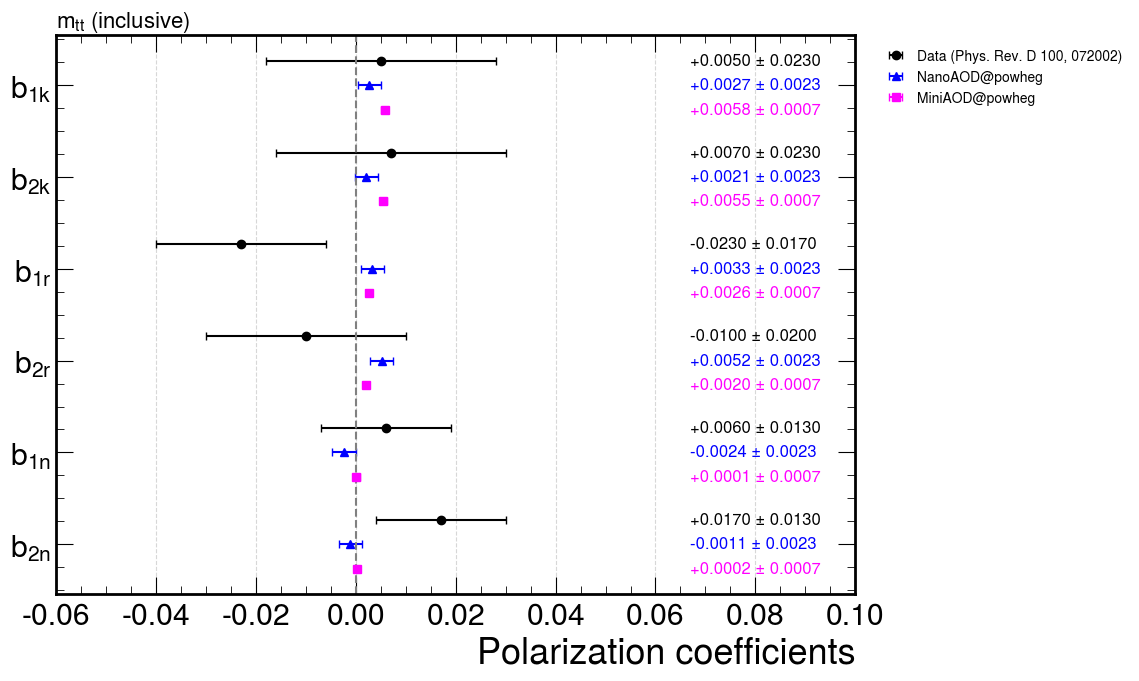

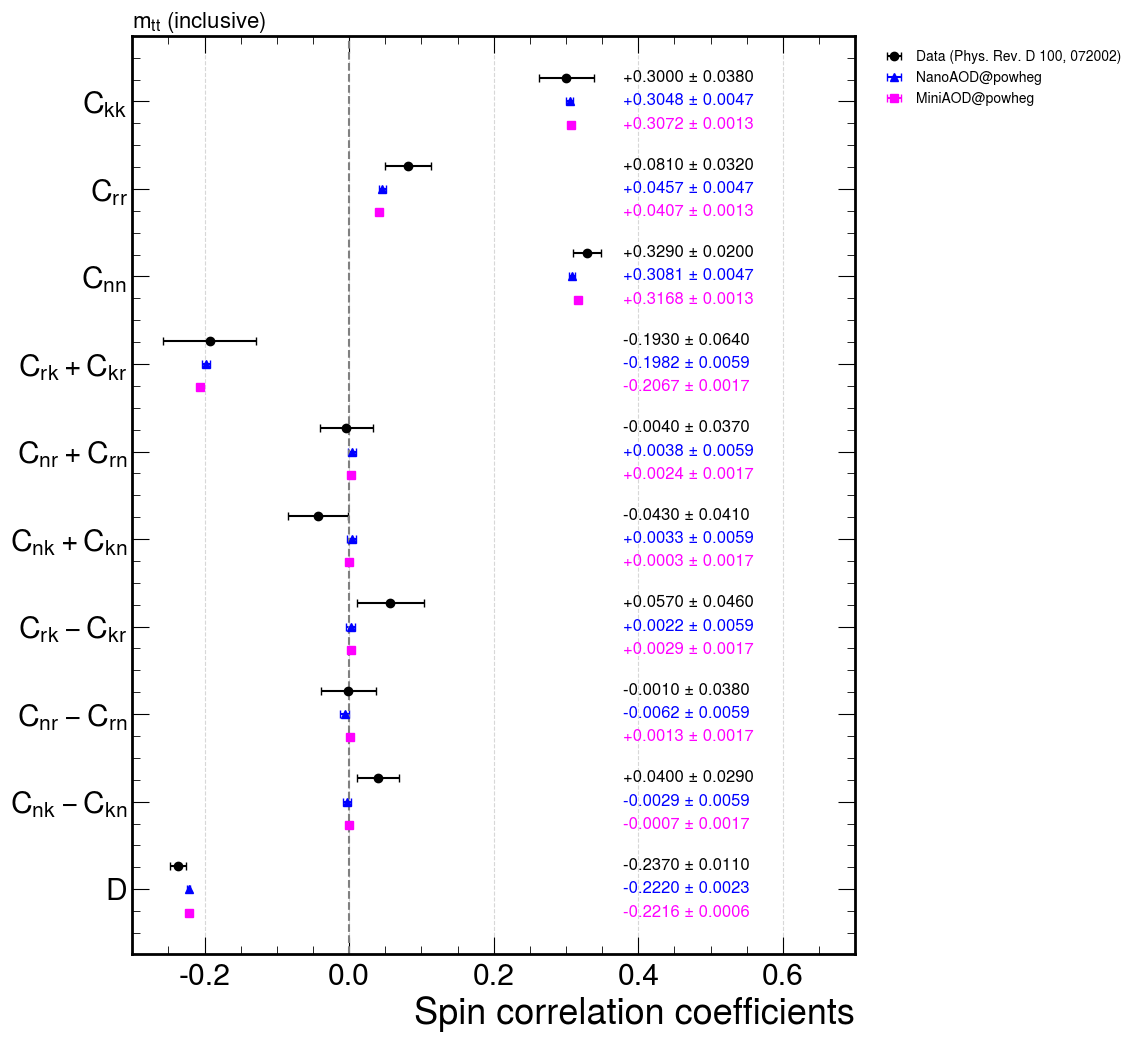

In [67]:
# Shared observables across all sources
polarization_obs = [k for k in measured_data if k.startswith(r'$b_') and k in results_miniaod_eft and k in results_nanoaod_eft]
spin_corr_obs = [k for k in measured_data if (k.startswith(r'$C_') or k == r'$D$') and k in results_miniaod_eft and k in results_nanoaod_eft]

# Save directory
save_directory = '/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Coeff_plots_comparison'

# Polarization plot
plot_comparison_eft_vs_data(
    polarization_obs,
    result_miniaod=results_miniaod_SM,
    result_nanoaod=results_nanoaod_SM,
    measured_data=measured_data,
    xlabel="Polarization coefficients",
    title=r"$ m_{tt} $ (inclusive)",
    save_dir=save_directory,
    xlim=(-0.06, 0.10),
    filename="polarization_vs_data_miniaod_nanoaod_SM.png"
)

# Spin correlation plot
plot_comparison_eft_vs_data(
    spin_corr_obs,
    result_miniaod=results_miniaod_SM,
    result_nanoaod=results_nanoaod_SM,
    measured_data=measured_data,
    xlabel="Spin correlation coefficients",
    title=r"$ m_{tt} $ (inclusive)",
    save_dir=save_directory,
    xlim=(-0.3, 0.7),
    filename="spincorr_vs_data_miniaod_nanoaod_SM.png"
)
